<a href="https://colab.research.google.com/github/rekalantar/StockPricePredictorLSTM_TensorFlow/blob/main/StockPricePredictor_TensorFlow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Introduction** 

Predicting stock prices has always been a popular topic in finance and machine learning. Accurate stock price predictions can help investors make informed decisions and maximize their returns. In this tutorial, we will demonstrate how to use PyTorch and an LSTM (long short-term memory) model to predict stock prices. LSTMs are a type of recurrent neural network that are particularly well-suited to time series data, making them a popular choice for stock market prediction.

**Load and Visualize Data**

The first step in any machine learning project is to collect and preprocess the data. In this case, we will use the Microsoft stock data from Yahoo Finance. We can use the yfinance library to scrape the data. We can start with installing the yfinance library:

In [1]:
!pip install -q yfinance

The dataframe has the following columns:

• Date: The date of the stock price\
• Open: The opening price of the stock\
• Close: The closing price of the stock\
• Volume: The trading volume of the stock\
• Dividends: The dividends paid to investors annually\
• Stock Splits: The stock price split

In [95]:
import yfinance as yf

# Get the Microsoft stock price data between 2016 and 2022 
data = yf.download('MSFT', start='2016-01-01', end='2022-12-31')

# View the last 10 data entries to identify datapoint columns
data.tail(10)

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-12-16,248.550003,249.839996,243.509995,244.690002,244.690002,86102000
2022-12-19,244.860001,245.210007,238.710007,240.449997,240.449997,29696400
2022-12-20,239.399994,242.910004,238.419998,241.800003,241.800003,25150800
2022-12-21,241.690002,245.619995,240.110001,244.429993,244.429993,23690600
2022-12-22,241.259995,241.990005,233.869995,238.190002,238.190002,28651700
2022-12-23,236.110001,238.869995,233.940002,238.729996,238.729996,21207000
2022-12-27,238.699997,238.929993,235.830002,236.960007,236.960007,16688600
2022-12-28,236.889999,239.720001,234.169998,234.529999,234.529999,17457100
2022-12-29,235.649994,241.919998,235.649994,241.009995,241.009995,19770700


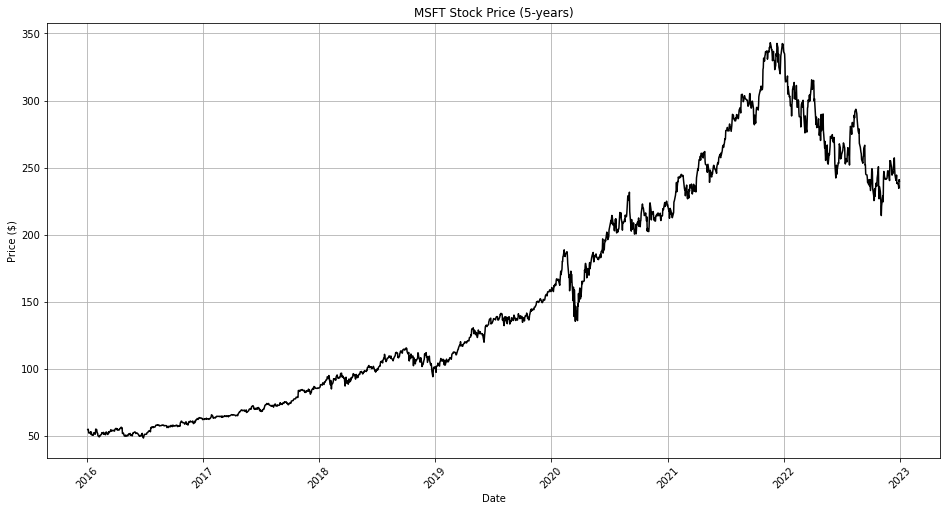

In [122]:
import matplotlib.pyplot as plt

# Plot the close price
plt.figure(figsize=(16,8))
plt.plot(data['Close'], color='black')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.ylabel('Price ($)')
plt.title('MSFT Stock Price (5-years)')
plt.grid(True)
plt.show()

**Preprocess Data**

Here, we preprocess financial data for use in training and testing a model. We extract the 'Close' column from the data and convert it to a NumPy array. The data is then scaled using the MinMaxScaler and divided into training and test sets. The code also creates input/output pairs from the training data, converts them to NumPy arrays, and reshapes them for use with an LSTM model. The test inputs are prepared in a similar way, and the test outputs are obtained from the 'values' array. Once these preparations are complete, the data is ready for use in training and testing a model.

In [123]:
import math
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Extract the 'Close' column from the data
close_prices = data['Close']

# Get the values from the 'Close' column as a NumPy array
values = close_prices.values

# Calculate the length of the training data by taking 80% of the total length of the 'values' array
training_data_len = math.ceil(len(values) * 0.8)

# Create a MinMaxScaler object and scale the values to the range [0, 1]
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(values.reshape(-1, 1))

# Split the scaled data into training and test sets
train_data = scaled_data[0: training_data_len, :]
test_data = scaled_data[training_data_len - 60: , : ]

# Initialize empty lists for the training and test inputs and outputs
x_train, y_train = [], []
x_test = []

# Loop through the training data and create input/output pairs
for i in range(60, len(train_data)):
    x_train.append(train_data[i - 60: i, 0])
    y_train.append(train_data[i, 0])

# Convert the training inputs and outputs to NumPy arrays
x_train = np.array(x_train)
y_train = np.array(y_train)

# Reshape the training inputs to be 3D for use with an LSTM model
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

# Loop through the test data and create input sequences
for i in range(60, len(test_data)):
    x_test.append(test_data[i - 60: i, 0])

# Convert the test inputs to a NumPy array and reshape to be 3D
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# Get the test outputs as a NumPy array from the 'values' array
y_test = values[training_data_len:]

In [124]:
print('x_train shape:', x_train.shape)
print('y_train shape:', y_train.shape)
print('x_test shape:', x_test.shape)
print('y_test shape:', y_test.shape)

x_train shape: (1350, 60, 1)
y_train shape: (1350,)
x_test shape: (352, 60, 1)
y_test shape: (352,)


**Create the LSTM Model**

The model defined in this code is a Sequential model, which means that it is composed of a linear stack of layers. The first layer is an LSTM layer with 100 units and a return_sequences parameter set to True. The second layer is also an LSTM layer with 100 units, but the return_sequences parameter is set to False.

The third and fourth layers are dense layers with 25 and 1 units, respectively. The model summary is then printed to give an overview of the model's architecture.

This model is suitable for time series prediction tasks such as stock price forecasting. The LSTM layers are well-suited for learning from sequential data, and the dense layers allow the model to learn more abstract patterns in the data.

In [100]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential()
model.add(layers.LSTM(100, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(layers.LSTM(100, return_sequences=False))
model.add(layers.Dense(25))
model.add(layers.Dense(1))
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (None, 60, 100)           40800     
                                                                 
 lstm_11 (LSTM)              (None, 100)               80400     
                                                                 
 dense_10 (Dense)            (None, 25)                2525      
                                                                 
 dense_11 (Dense)            (None, 1)                 26        
                                                                 
Total params: 123,751
Trainable params: 123,751
Non-trainable params: 0
_________________________________________________________________


In [125]:
# Inspect data shapes
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((1350, 60, 1), (1350,), (352, 60, 1), (352,))

**Train the Model**

The model is compiled using the 'adam' optimizer and the 'mean_squared_error' loss function. The optimizer is responsible for updating the model's weights during training, and the loss function measures how well the model is doing on the training data.

After compiling the model, the code calls the fit method to start the training process. The model is trained on the x_train and y_train data using a batch size of 1 and 10 epochs. During each epoch, the model will update its weights based on the loss it experiences on the training data. The number of epochs is a hyperparameter that can be adjusted to achieve better performance.

This code will train the model to make predictions on the time series data it has been given. The trained model can then be used to make predictions on new, unseen data.

In [102]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, batch_size= 1, epochs=10)

Epoch 1/10
1350/1350 [==============================] - 31s 22ms/step - loss: 9.8989e-04
Epoch 2/10
1350/1350 [==============================] - 29s 21ms/step - loss: 5.3372e-04
Epoch 3/10
1350/1350 [==============================] - 29s 22ms/step - loss: 3.9441e-04
Epoch 4/10
1350/1350 [==============================] - 29s 21ms/step - loss: 2.7770e-04
Epoch 5/10
1350/1350 [==============================] - 29s 21ms/step - loss: 3.0783e-04
Epoch 6/10
1350/1350 [==============================] - 30s 22ms/step - loss: 2.0318e-04
Epoch 7/10
1350/1350 [==============================] - 29s 22ms/step - loss: 2.9125e-04
Epoch 8/10
1350/1350 [==============================] - 29s 22ms/step - loss: 2.3069e-04
Epoch 9/10
1350/1350 [==============================] - 29s 22ms/step - loss: 1.8130e-04
Epoch 10/10
1350/1350 [==============================] - 29s 22ms/step - loss: 2.3230e-04


**Validate the Model**

First, the model's predict method is called on the x_test data to generate predictions. These predictions are then transformed back to their original scale using the scaler's inverse_transform method.

Next, the root mean squared error (RMSE) is calculated as a measure of how well the model performed on the test data. The RMSE is a widely used metric for evaluating the performance of a model on continuous data. It is calculated as the square root of the mean squared error (MSE) between the predictions and the true values.

Finally, the RMSE is printed to the console. A lower RMSE value indicates that the model is making predictions that are closer to the true values.

In [121]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
rmse = np.sqrt(np.mean(predictions - y_test)**2)
print('Root mean squared error:', rmse)

11/11 [==============================] - 0s 28ms/step
Root mean squared error: 1.252763574773615


**Visualize Prediction Data**

In [130]:
data = data.filter(['Close'])
train = data[:training_data_len]
validation = data[training_data_len:]
validation['Predictions'] = predictions
train.reset_index(inplace = True)
validation.reset_index(inplace = True)

<ipython-input-130-4429499f47f4>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [132]:
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scatter(x=train.Date, y=train.Close, mode='lines', name='Actual Price (train)'))
fig.add_trace(go.Scatter(x=validation.Date, y=validation.Close, mode='lines', name='Actual Price (test)'))
fig.add_trace(go.Scatter(x=validation.Date, y=validation.Predictions, mode='lines', name='Predicted price'))
fig.update_layout(
        title="Time series Forecasting using LSTM",
        xaxis_title="Date-Time",
        yaxis_title="Values",
        legend_title="Legend",
)
fig.show()

This code processes the original data set and the model's predictions to prepare them for visualization.

First, the 'Close' column of the data is extracted and filtered to create a new data set. Then, this data set is divided into training and validation sets using the training_data_len variable, which was calculated earlier as the length of the training data.

The model's predictions are then added to the validation set as a new column called 'Predictions'. Finally, both the train and validation sets are reset to have a sequential index.

These operations are likely being performed in order to prepare the data for visualization, such as creating a plot of the original data and the model's predictions side by side. Resetting the indices allows the data to be plotted on a continuous time axis.